# Homework 1: Named Entity Recognition (NER) with Sequence Labeling Models
## CS4740/5740 Fall 2022

### Milestone Submission Due: **September 15, 2022 (11:59 PM)** 

### Project Submission Due: **September 27, 2022 (11:59 PM)**

Should there be major updates to this document, we will announce them on [Ed Stem](https://edstem.org/us/courses/26793/discussion/).  Minor updates are documented on [this particular much-beloved thread](https://edstem.org/us/courses/26793/discussion/1739296).






**Names:**

**Netids:**




**Editing your version of this notebook:** One partner should make a copy of this notebook and share it with your partner.  **However**, because of synchronization issues (even though Colab works with Google Drive), changes made in this notebook at the same time from different computers/browser windows may not save. We will go so far as to recommend that you close the tab with this notebook when you are not working on it so your partner doesn't face sync issues.



**Collaboration policy:** please be sure to check the collaboration policy on the [course website](https://courses.cs.cornell.edu/cs4740/2022fa/)!



> Assignment authors & testers: CS 4740/5740 professors and TAs from this and previous semesters, Chenxin Fang, Meghana Srivastava, Khonzoda Umarova, as well as Ruizhe Wang, Han Xia, and Heather Zhang.

# **Introduction**
---

In this project, you will tackle the **Named Entity Recognition** task: you'll implement models that identify named entities in text and tag them with the appropriate label. A primer on this task is provided further on.  We will treat this as a **sequence-tagging task**: for each token in the input text, assign one of the following 5 entity labels -- **ORG** (Organization), **PER** (Person), **LOC** (Location), **MISC** (Miscellaneous), and **O** (Not Named Entity) -- as well as a BIO-format prefix **B-** (token is the *beginning* of a named entity) or **I-** (token is *inside* a named entity). Overall, this yields 9 different labels: **B-ORG, I-ORG, B-PER, I-PER, B-LOC, I-LOC, B-MISC, I-MISC** and **O**.

For this project, you will implement two sequence labeling approaches:
- Model 1 : a Hidden Markov Model (HMM)
- Model 2 : a Maximum Entropy Markov Model (MEMM)/Logistic Regression classifier (also known as a MaxEnt classifier). Feature engineering is strongly suggested for this model!

A key component of both models is implementation of the Viterbi algorithm, which we will use to find the most likely tag sequence to assign to an input text.

## **Logistics**

---

- You are **strongly encouraged** to work in **groups of 2 students**. Students in the same group will get the same grade. Thus, you should make sure that everyone in your group contributes to the project. 
- **Do not form teams of two on Kaggle** (You *will* form teams on a different platform; details TBA) because submitting separately gives you more tries, which is useful when experimenting with different models. 
- **Before submitting your predictions on Kaggle**, please rename your "Kaggle team" (since you and your partner are not forming your group on the Kaggle platform, this "team" would actually only include you) to be your NetID (eg: `team_ku47`). You can do so under `Team` tab of the competition. 
- A part of your submission would involve uploading your notebook (details would be provided soon!). So, please enter all code and answer all the questions in this colab notebook.
  - Your code must have docstrings/comments documenting the meaning of parameters and important parameter-like variables.
- In this assignment you are asked to make two submissions:
  1. Intermediate **milestone submission due on 9/15/22 (11:59 PM)**. For this, please 1) have your teams formed (mechanism TBA) and  2) submit predictions of your first model (HMM) on Kaggle. This means that you should aim to complete Part 1 and Part 2 of the assignment by this milestone. Points will be awarded for meeting the milestone deadline, but we will only grade for completion, not correctness. 
  2. The **final homework submission due on 9/27/22 (11:59 PM)**. (details TBA)
- Please be sure to consult the [list](https://docs.google.com/document/d/1-QmpkZYJDCM4gQQ9sZW2EwD5ltYy1CFjlJTbhD0Be-A/edit?usp=sharing) of banned packages/libraries before you start implementing your models. Note that this list may get updated.



## **Advice**

---

1. Please read through the entire notebook before you start coding. That might inform your code structure.
2. An assignment outline and grading breakdown (subject to minor adjustments) is found below; please consult it.
3. The project is somewhat open ended. We will ask you to implement the models, but in some cases precise data structures and so on can be chosen by you. However, to integrate with Kaggle, you will need to submit Kaggle predictions using the given evaluation code (more instructions later).

<a name="outline"></a>
## **Assignment outline and grading breakdown**
- [Part 1](#part1)
  - [Q1](#q1) [10 pts]
- [Part 2](#part2)
  - [Unknown Word Handling](#unknowns_handling) [15 pts]
  - [HMM Implementation](#hmm_implementation) [20 pts]
  - [Viterbi Implementation](#viterbi_implementation) [20 pts]
  - [Validation](#validation_data) [3 pts]
  - [Q2.1](#q2.1) [5 pts]
  - [Q2.2](#q2.2) [5 pts]
  - [Q2.3](#q2.3) [5 pts]
  - [Q2.4](#q2.4) [5 pts]
- [Part 3](#part3)
  - [Features](#features) [35 pts]
  - [MEMM Implementation](#memm_implementation) [25 pts]
  - [Q3.1](#q3.1) [5 pts]
  - [Q3.2](#q3.2) [5 pts]
  - [Q3.3](#q3.3) [5 pts]
  - [Q3.4](#q3.4) [5 pts]
- [Part 4](#part4)
  - [Q4.1](#q4.1) [7 pts]
  - [Q4.2](#q4.2) [7 pts]
  - [Q4.3](#q4.3) [7 pts]
- [Part 5](#part5)
  - [Q5](#q5)


Meeting the milestone deadline [10 pts];

Outperforming our baseline on Kaggle [15 pts];



## **Named Entity Recognition: Review**

---

NER refers to the information extraction technique of identifying and categorizing key information about entities within textual data. NER is important for:
  - Detecting entities in search engines and voice assistants for more relavent search results.
  - Automatically parsing resumes.
  - ...and much more!

In our dataset named entity tags are formatted in BIO/IOB format. With this format, entity tags get a prefix. Prefix "B-" is added to the first word/token of the entity name. All following tokens that are part of the same entity name would get prefix "I-". 

Here is an example sentence: "ZIFA
said
Renate
Geotschel
of
Austria
won the women's World Cup  downhill race in Germany."
Entity "Renate Goetschl" gets "Renate" (B-PER) and "Goestchl" (I-PER). Similarly, for "World Cup" we'd have "World" (B-MISC) and "Cup" (I-MISC). If an entity only has one token, then its entity tag would still have prefix "B-". "O" is used to denote tokens that are not part of any named entity. Thus, from the example above, we'd have:

```"ZIFA" B-ORG```

 ```"said" O```

 ```"Renate" B-PER```

 ```"Goetschl" I-PER```

 ```"of" O```

 ```"Austria" B-LOC```

 ```"won" O```

 ```"the" O```

 ```"women's" O```

 ```"World" B-MISC```

 ```"Cup" I-MISC```

 ```"downhill" O```

 ```"race" O```

 ```"in" O```

 ```"Germany" B-LOC```


Although NER is predominantly handled by deep learning approaches, for now let's use HMMs and MEMMs. 


To read more on NER, we refer to any of the following sources:
1. Medium post [1](https://umagunturi789.medium.com/everything-you-need-to-know-about-named-entity-recognition-2a136f38c08f) and [2](https://medium.com/mysuperai/what-is-named-entity-recognition-ner-and-how-can-i-use-it-2b68cf6f545d).
2. Try out [this](https://demo.allennlp.org/named-entity-recognition/named-entity-recognition) AlllenNLP demo! Please note that this demo uses a slightly different format of NER tags.

## **Evaluation: Entity Level Mean F1**

---

The standard evaluation measures to report for NER are recall, precision, and F1 score
(also called F-measure) evaluated at the **named entity level** (not at the token level). The code for this has been provided later under the validation section under Part 2. Please use this code when evaluating your models. 


If P and T are the sets of predicted and true *named entity spans*, respectively, (e.g, the five named entity spans in the above example are "Zifa", "Renate Goetschl", "Austria", "World Cup", and "Germany") then

####<center>Precision = $\frac{|\text{P}\;\cap\;\text{T}|}{|\text{P}|}$ and Recall = $\frac{|\text{P}\;\cap\;\text{T}|}{|\text{T}|}$.</center><br/>


####<center>F1 = $\frac{2 * \text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}$. </center><br/>

For each type of named entity, e.g. *LOC*ation, *MISC*ellaneous, *ORG*anization and *PER*son, we calculate the F1 score as shown above, and take the mean of all these F1 scores to get the **Entity Level Mean F1** score for the test set. If $N$ is the total number of labels (i.e., named entity types), then

####<center>Entity Level Mean F1 = $\frac{\sum_{i = 1}^{N} \text{F1}_{{label}_i}}{N}$. </center>

More details under the validation section in Part 2.



<a name="part1"></a>
# **Part 1: Dataset**
[[^^^]](#outline) 

Our data is a modified version of the WikiNEuRal ([ Tedeschi et al.](https://aclanthology.org/2021.findings-emnlp.215.pdf)) dataset.

Load the dataset as follows:
  1. Obtain the data from Data tab of the [Kaggle competition](https://www.kaggle.com/t/200697e4726f448986930dd4e823e957).
  2. Unzip the data. Put it into your Google Drive, run the cells below to mount it to Colab:


In [12]:
# from google.colab import drive
# import os
# drive.mount('/content/drive', force_remount=True)

In [4]:
import json

# TODO: please change the line below with your drive organization
path = os.path.join(os.getcwd(), "Data")

with open(os.path.join(path,'train.json'), 'r') as f:
     train = json.loads(f.read())

with open(os.path.join(path,'val.json'), 'r') as f:
     val = json.loads(f.read())

with open(os.path.join(path,'test.json'), 'r') as f:
     test = json.loads(f.read())

Here's a few things to note about the dataset above:
1. We have loaded 3 `.json` files: for training, validation, and testing.
2. The train and validation files contain the following 3 fields (each is a nested list): 
  - **'text'** - actual input tokens
  - **'NER'** - the token-level entity tag 
  - **'index'** - index of the token in the dataset
3. The test data only has **'text'**, and **'index'** fields. You will need to submit your prediction of the **'NER'** tag to Kaggle.


### **Q1: Initial Data Observations**

In the space below please add your code for dataset explorations for Q1.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

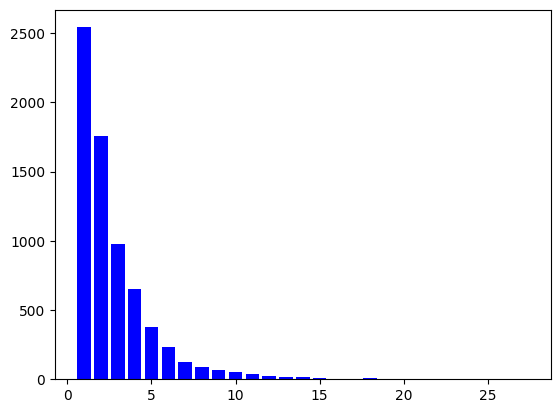

In [16]:
## add your code here
#print(test['text'],len(test['text']), test['index'], len(test['index']))
#print(train['text'][0])
hist = {}
for seq in train['NER'] :
  removedzeroes = [tag for tag in seq if len(tag) > 1]
  hist[len(removedzeroes)] = hist.get(len(removedzeroes), 0) + 1

plt.bar(hist.keys(), hist.values(), color='b')

plt.show()

{'NER': array(['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG',
       'I-PER'], dtype='<U6'), 'Frequency': array([4060, 2815, 1725, 3016, 1451, 2566, 1431, 2217])}
the distribution of unique labels
('length of the training set: ', 7000)


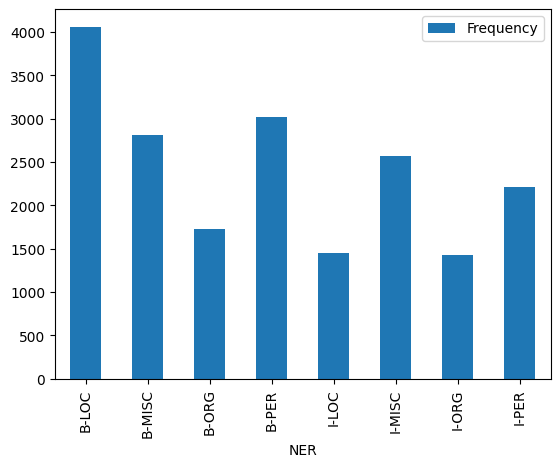

In [52]:
# number of named entity instances
train_df = pd.DataFrame(train)
train_ner = np.hstack(train_df.NER.to_numpy())
unique_entities = np.unique(train_ner, return_counts=True)
index_tuple = np.where(unique_entities[0] == 'O')
index_o = index_tuple[0][0]
ue_dict = {'NER': np.delete(unique_entities[0], index_o), 'Frequency': np.delete(unique_entities[1], index_o)}
unique_entities = pd.DataFrame(ue_dict)

print("the distribution of unique labels")
unique_entities.plot(kind='bar', x='NER')

# lengths of the training set
train_len = len(train['NER'])
print(("length of the training set: ", train_len))

<a name="q1"></a>
[[^^^]](#outline) 

What are your initial observations after you explore the dataset?  Provide some quantitative data exploration. Assess dataset size, document lengths and the token-level NER class distribution, and the entity-level NER class distribution (skipping the 'O' label for the latter). Give some examples of sentences with their named entities bracketed, e.g. [[B-LOC Romania] state budget soars in June .] and [[B-ORG Zifa] said [B-PER Renate] [I-PER Goetschl] of [B-LOC Austria]...]. 


#### **A1:**

... add your answers here

<a name="part2"></a>
# **Part 2: Hidden Markov Model**
[[^^^]](#outline) 
---
In this part of the assignment, you will:
1. Implement code for counting and smoothing of labels and words, as well as unkown word handing, as necessary to support the Viterbi algorithm. 
2. Build a Hidden Markov Model in accordance with the provided function headers. **You may NOT change the function specifications.** Please ensure that your code is clear, concise, and, most important of all, modular. This means you should break your implementation down into smaller functions or write it within a class. Please compute all probabilities in natural log when building the HMM.
3. Implement the **Viterbi algorithm**, that can be used to infer token-level labels (identifying the appropriate named entity) for an input document. This process is commonly referred to as **decoding**. Bigram-based Viterbi is $ \mathcal{O}(sm^2)$ where *s* is the length of the sentence and *m* is the number of tags. Your implementation should have similar efficiency. The code for this can be used later on for the MEMM too.

### References
You may find chapters [3](https://web.stanford.edu/~jurafsky/slp3/3.pdf) and [8](https://web.stanford.edu/~jurafsky/slp3/8.pdf) of Jurafsky and Martin book useful. In particular, section 3.4.1 covers ways to handle unknown words, and section 3.5 goes over smoothing. 

<a name="unknowns_handling"></a>
## **Unknown Word Handling**
[[^^^]](#outline) 
---

In [ ]:
# Implement unknown word handling here! You may do this any way that you please


<a name="hmm_implementation"></a>
## **HMM Implementation**
[[^^^]](#outline) 
---

In the skeleton code below, we have broken down the HMM into its three components: the transition matrix, the emission matrix, and the start state probabilities. We suggest you implement them separately and then use them to build the HMM.


In [10]:
# Returns the transition probabilities.
from distutils.command.build import build


def build_transition_matrix(labels, k=0):
  """
    Returns a dictionary that has tuples of every label bigram as keys, and
    the associated value being the respective transition probabilities (in 
    natural log).

    Eg. {("O", "B-ORG"): -9.98690147425591, 
         ("B-LOC", "I-LOC"): -3.69537214,
         ...,
         ...,
        }
    
    :parameter labels: A list where each element represents a sentence, 
    and each sentence is a list of NER labels for each of its tokens. (Eg. 
    [['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O'], [...], ...])
    :type labels: List[List[String]]
    :parameter k: an optional parameter for smoothing
    :type k: int
    """
  transition = {}
  counts = {}
  unique_labels = ['start', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'O']
  #initialize transition matrix and add-k smoothing 
  for lbl1 in unique_labels :
    counts[lbl1] = k
    for lbl2 in unique_labels :
      if lbl2 != 'start' :
        transition[(lbl1, lbl2)] = k

  #count the number of transitions
  for seq in labels :
    for i in range(len(seq)) :
      if (i == 0) :
        prev = 'start'
      else :
        prev = seq[i - 1]
      
      transition[(prev, seq[i])] += 1
      counts[prev] += 1

  #normalize and take log
  for lbl1 in unique_labels :
    for lbl2 in unique_labels :
      if lbl2 != 'start' :
        transition[(lbl1, lbl2)] = np.log(transition[(lbl1, lbl2)]/counts[lbl1])

  return transition

transition = build_transition_matrix(val['NER'], 2)
#print(val['NER'])
print(transition)

{('start', 'B-ORG'): -4.204692619390966, ('start', 'I-ORG'): -5.303304908059076, ('start', 'B-PER'): -3.288401887516811, ('start', 'I-PER'): -5.303304908059076, ('start', 'B-LOC'): -3.4315027311574844, ('start', 'I-LOC'): -5.303304908059076, ('start', 'B-MISC'): -4.61015772749913, ('start', 'I-MISC'): -5.303304908059076, ('start', 'O'): -0.0775582343458745, ('B-ORG', 'B-ORG'): -3.8815637979434374, ('B-ORG', 'I-ORG'): -0.49717353459766345, ('B-ORG', 'B-PER'): -3.8815637979434374, ('B-ORG', 'I-PER'): -3.8815637979434374, ('B-ORG', 'B-LOC'): -3.8815637979434374, ('B-ORG', 'I-LOC'): -3.8815637979434374, ('B-ORG', 'B-MISC'): -3.8815637979434374, ('B-ORG', 'I-MISC'): -3.8815637979434374, ('B-ORG', 'O'): -0.8858315243894466, ('I-ORG', 'B-ORG'): -3.7954891891721947, ('I-ORG', 'I-ORG'): -1.0229004669324133, ('I-ORG', 'B-PER'): -3.7954891891721947, ('I-ORG', 'I-PER'): -3.7954891891721947, ('I-ORG', 'B-LOC'): -3.7954891891721947, ('I-ORG', 'I-LOC'): -3.7954891891721947, ('I-ORG', 'B-MISC'): -3.79

In [ ]:
# Returns the transition probabilities.
def build_transition_matrix(labels, k=0):
  """
    Returns a dictionary that has tuples of every label bigram as keys, and
    the associated value being the respective transition probabilities (in 
    natural log).

    Eg. {("O", "B-ORG"): -9.98690147425591, 
         ("B-LOC", "I-LOC"): -3.69537214,
         ...,
         ...,
        }
    
    :parameter labels: A list where each element represents a sentence, 
    and each sentence is a list of NER labels for each of its tokens. (Eg. 
    [['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O'], [...], ...])
    :type labels: List[List[String]]
    :parameter k: an optional parameter for smoothing
    :type k: int
    """
  transition = {}
  total = {}
  unique_labels = ['B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'O']
  #initialize transition matrix and add-k smoothing 
  for lbl1 in unique_labels :
    for lbl2 in unique_labels :
      transition[(lbl1, lbl2)] = k
    total[lbl1] = k * len(unique_labels)
  
  # loop through labels
  for sentence in labels:
    for word in range(len(sentence)-1):
      lbl1 = sentence[word]
      lbl2 = sentence[word+1]
      transition[(lbl1, lbl2)] += 1
      total[lbl1] += 1

  # log
  for trans, val in transition.iteritems():
    lbl1 = trans[0]
    lbl1_total = total[lbl1]
    transition[trans] = np.log(val/lbl1_total)

  return transition

In [ ]:
# Returns the emission probabilities.
def build_emission_matrix(tokens, labels, k=0):
  """
    Returns a dictionary that has label-token tuples as keys, and emission 
    probabilities (in natural log) for each respective label-token pair as values.  

    Eg. {("O", "Because"): -10.133904545421267, 
         ("I-PER", "Markov"): -7.428569227340841,
         ...,
         ...,
        }
    
    :parameter tokens: A list where each element represents a sentence, 
    and each sentence is a list of its tokens. (Eg. [['The', 'most', 
    'significant', 'damage', 'was', 'on', 'Tortola', '.'], [...], ...])
    :type tokens: List[List[String]]
    :parameter labels: A list where each element represents a sentence, 
    and each sentence is a list of NER labels for each of its tokens. (Eg. 
    [['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O'], [...], ...])
    :type labels: List[List[String]]
    :parameter k: an optional parameter for smoothing
    :type k: int
    """
  pass

In [ ]:
# Returns the starting state probabilities.
def get_start_state_probs(labels, k=0):
  """
    Returns a dictionary that has labels for keys, and the respective state 
    probabilities (in natural log) for values.  

    Eg. {"O": -10.133904545421267, 
         "I-PER": -7.428569227340841,
         ...,
         ...,
        }
    
    :parameter labels: A list where each element represents a sentence, 
    and each sentence is a list of NER labels for each of its tokens. (Eg. 
    [['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O'], [...], ...])
    :type labels: List[List[String]]
    :parameter k: an optional parameter for smoothing
    :type k: int
    """
  pass

In [ ]:
# Takes in the tokens & labels and returns a representation of the HMM.
# Call the three functions above in this function to build your HMM.
def build_hmm(tokens, labels):
  pass

<a name="viterbi_implementation"></a>
## **Viterbi Implementation**
[[^^^]](#outline) 
---

At the end of your implementation, we expect a function or class that maps a sequence of tokens (observation) to a sequence of labels via the Viterbi algorithm.

In [ ]:
# Takes in the HMM built above and an observation (i.e. a list of tokens),
# and returns a list with predicted named entity mappings for the tokens.
# The returned list should be the same length as the input obeservation.
def viterbi(hmm, observation):
  pass

In [ ]:
# Here's a sample observation that you can use to test your code
obs_1 = ['Cornelll',
 'University',
 'is',
 'located',
 'in',
 'Ithaca',
 'and',
 'was',
 'founded',
 'by',
 'Ezra',
 'Cornell']

# Uncomment and fill out the following line to test your implementation:
# viterbi(obs=obs_1, hmm=?)

## **Validation Step**
<a name="validation_data"></a>
[[^^^]](#outline) 
---

In this part of the project, we expect you to train your HMM model (i.e., get transition and emission probabilities) on the labeled training data and evaluate it on the validation data. Report **Entity Level Mean F1**, which was explained earlier. Please use the code we have provided below to compute this metric.

Please also take a look into your misclassified cases, as we will be performing error analysis in the *Evaluation* section. We expect smoothing, unknown word handling and correct emission (i.e., lexical generation) probabilities.

Consider the example below. After getting a sequence of NER labels for the sequence of tokens from your Viterbi algorithm implementation, you need to convert the sequence of tokens, associated token indices and NER labels into a format which can be used to calculate **Entity Level Mean F1**. We do this by finding the starting and ending indices of the spans representing each entity (as given in the corpus) and adding it to a list that is associated with the label with which the spans are labelled. To score your validation data on Google Colab or your local device, you can get a dictionary from the function **format_output_labels** on both the predicted and true label sequences, and use the two dictionaries as input to the **mean_f1** function.

NOTE: We do **not** include the spans of the tokens labelled as "O" in the formatted dictionary output.

In [ ]:
def format_output_labels(token_labels, token_indices):
    """
    Returns a dictionary that has the labels (LOC, ORG, MISC or PER) as the keys, 
    with the associated value being the list of entities predicted to be of that key label. 
    Each entity is specified by its starting and ending position indicated in [token_indices].

    Eg. if [token_labels] = ["B-ORG", "I-ORG", "O", "O", "B-ORG"]
           [token_indices] = [15, 16, 17, 18, 19]
        then dictionary returned is 
        {'LOC': [], 'MISC': [], 'ORG': [(15, 16), (19, 19)], 'PER': []}

    :parameter token_labels: A list of token labels (eg. B-PER, I-PER, B-LOC, I-LOC, B-ORG, I-ORG, B-MISC, OR I-MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = {"LOC":[], "MISC":[], "ORG":[], "PER":[]}
    prev_label = 'O'
    start = token_indices[0]
    for idx, label in enumerate(token_labels):
      curr_label = label.split('-')[-1]
      if label.startswith("B-") or (curr_label != prev_label and curr_label != "O"):
        if prev_label != "O":
            label_dict[prev_label].append((start, token_indices[idx-1]))
        start = token_indices[idx]
      elif label == "O" and prev_label != "O":
        label_dict[prev_label].append((start, token_indices[idx-1]))
        start = None

      prev_label = curr_label
    if start is not None:
      label_dict[prev_label].append((start, token_indices[idx-1]))
    return label_dict

In [ ]:
# Code for mean F1

import numpy as np

def mean_f1(y_pred_dict, y_true_dict):
    """ 
    Calculates the entity-level mean F1 score given the actual/true and 
    predicted span labels.
    :parameter y_pred_dict: A dictionary containing predicted labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_pred_dict: Dict<key [String] : value List[Tuple]>
    :parameter y_true_dict: A dictionary containing true labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_true_dict: Dict<key [String] : value List[Tuple]>

    Implementation modified from original by author @shonenkov at
    https://www.kaggle.com/shonenkov/competition-metrics.
    """
    F1_lst = []
    for key in y_true_dict:
        TP, FN, FP = 0, 0, 0
        num_correct, num_true = 0, 0
        preds = y_pred_dict[key]
        trues = y_true_dict[key]
        for true in trues:
            num_true += 1
            if true in preds:
                num_correct += 1
            else:
                continue
        num_pred = len(preds)
        if num_true != 0:
            if num_pred != 0 and num_correct != 0:
                R = num_correct / num_true
                P = num_correct / num_pred
                F1 = 2*P*R / (P + R)
            else:
                F1 = 0      # either no predictions or no correct predictions
        else:
            continue
        F1_lst.append(F1)
    return np.mean(F1_lst)

In [ ]:
# Usage using above example

pred_token_labels = ["B-ORG", "O", "B-PER", "I-PER", "O", "B-LOC", "O", "O", "O", "O", "B-MISC", "O", "O", "O", "O", "B-LOC"]
true_token_labels = ["B-ORG", "O", "B-PER", "I-PER", "O", "B-LOC", "O", "O", "O", "O", "B-MISC", "I-MISC", "O", "O", "O", "B-LOC"]
token_indices = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

y_pred_dict = format_output_labels(pred_token_labels, token_indices)
print("y_pred_dict is : " + str(y_pred_dict))
y_true_dict = format_output_labels(true_token_labels, token_indices)
print("y_true_dict is : " + str(y_true_dict))

print("Entity Level Mean F1 score is : " + str(mean_f1(y_pred_dict, y_true_dict)))

y_pred_dict is : {'LOC': [(18, 18), (28, 27)], 'MISC': [(23, 23)], 'ORG': [(13, 13)], 'PER': [(15, 16)]}
y_true_dict is : {'LOC': [(18, 18), (28, 27)], 'MISC': [(23, 24)], 'ORG': [(13, 13)], 'PER': [(15, 16)]}
Entity Level Mean F1 score is : 0.75


In [ ]:
# Evaluate/validate your model here

<a name="q2.1"></a>
[[^^^]](#outline) 
## **Q2.1: Explain your HMM Implementations**

Explain how you implemented the HMM including the Viterbi algorithm. Make clear which parts were implemented from scratch vs. obtained via an existing package (review the Logistics section for information on packages that are not allowed). Explain and motivate any design choices providing the intuition behind them.


#### **A2.1:**

... add your answers here

<a name="q2.2"></a>
[[^^^]](#outline) 
## **Q2.2: Results Analysis**

Explain here how you evaluated the models. Summarize the performance of your system and any variations that you experimented with on the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis.


#### **A2.2:**

... add your answers here

<a name="q2.3"></a>
[[^^^]](#outline) 
## **Q2.3: Error Analysis**
When did the system work well? When did it fail?  Any ideas as to why? How might you improve the system?


#### **A2.3:**

... add your answers here

<a name="q2.4"></a>
[[^^^]](#outline) 
## **Q2.4: What is the effect of unknown word handling and smoothing?**

#### **A2.4:**

... add your answers here

<a name="part3"></a>
# **Part 3: Maximum Entropy Markov Model** 
[[^^^]](#outline) 
---

In this section, you will implement a Maximum Entropy Markov Model (**MEMM**) to perform the same NER task. Your model should consist of a MaxEnt classifier with Viterbi decoding. 

1. We have already performed tokenizations for documents. You can either use a MaxEnt classifier from an existing package or write the MaxEnt code yourself. **Important note:  MaxEnt classifiers are statistically equivalent to multi-class logistic regression, so you can use packages for multi-class LR instead of MaxEnt.**

2. Use the classifier to learn a probability $P(t_i|features)$. You may replace either the lexical generation probability – $P(w_i|t_i)$ – or the transition probability – $P(t_i|t_{i−1})$ – in the HMM with it, or you may replace the entire *lexical generation probability * transition probability*  calculation – $P (w_i|t_i) ∗ P (t_i|t_{i−1)} – $ in the HMM with it. 

3. To train such a classifier, you need to pick some feature set. The content of the feature set is up to you, but try different ones, and evaluate your choices on the validation set. Pick the feature set that performs overall the best according to the F1 measure. If you draw inspiration for your features from external sources, please link them in the code.
  * While there are many directions to take when looking for features, you may start by exploring parts of speech that appear in sentences. There are several libraries (ex. [nltk](https://www.nltk.org/book/ch05.html)) that process sentences and identify parts of speech. If you end up using a library to extract parts of speech tags or other features, please indicate this in your asnwer to Q3.1.

4. Use your own implementation of the **Viterbi algorithm**, which you can modify from the one you developed for the HMM model. You will need the probabilities that you obtain from the MaxEnt classifier. 

5. Remember to use same training and validation split when evaluating the MEMM to have a **fair comparison** with your **HMM model**.


Please also take a look into your misclassified cases, as we will be performing error analysis in Part 4. 





---
Here's a summary of the workflow for Part 3:

![alt text](https://drive.google.com/uc?export=view&id=14VfjW3yDyXLojWM_u0LeJYdDOSLkElBn)




Note that we have not provided any skeleton code for how you should do feature engineering since this is meant to be an open ended task and we want you to experiment with the dataset. However, please remember to make sure that you code is concise, clean, and readable! Ultimately, we expect a function or class  mapping a sequence of tokens to a sequence of labels. At the end of this section you should have done the following:
1. Extract Features
2. Build & Train MaxEnt
3. Call Viterbi when evaluating

### References
You may find [chapter 8](https://web.stanford.edu/~jurafsky/slp3/8.pdf) of Jurafsky and Martin book useful. In particular, you could consider section 8.5.2 for features in NER. 

<a name="features"></a>
## **Feature Engineering**
[[^^^]](#outline) 
---

In [ ]:
# Your implementation here

<a name="memm_implementation"></a>
## **MEMM Implementation**
[[^^^]](#outline) 
---

In [ ]:
# Your implementation here

### **Validation**
---
In this section we want you to run your MaxEnt model on the validation dataset you extracted earlier. We want you to play around with different combinations of features in order to find which features work the best for your implementation. You will be asked to write about this process in detail in written question 3.3 so please spend time experimenting with features! Once again, please use the code we provided for computing Entity Level Avg F1 earlier when validating your model.

In [ ]:
# Run your model on validation set
# You will need to 
# 1. Call your function above to get a prediction result on Validation Set
# 2. Report Metrics
# (See if you need to modify your feature set)

<a name="q3.1"></a>
[[^^^]](#outline) 

## **Q3.1: Implementation Details**
Explain how you implemented the MEMM and whether/how you modified Viterbi (e.g. which algorithms/data structures you used, what features are included). Make clear which parts were implemented from scratch vs. obtained via an existing package.


#### **A3.1:**

... add your answers here

<a name="q3.2"></a>
[[^^^]](#outline) 

## **Q3.2: Results Analysis**
Explain here how you evaluated the MEMM model. Summarize the performance of your system and any variations that you experimented with the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis.


#### **A3.2:**

... add your answers here

<a name="q3.3"></a>
[[^^^]](#outline) 

## **Q3.3: Feature Engineering**
What features are considered most important by your MaxEnt Classifier? Why do you think these features make sense? Describe your experiments with feature sets. An analysis on feature selection for the MEMM is required – e.g. what features **help most**, why? An **error analysis** is required – e.g. what sorts of errors occurred, why?

#### **A3.3:**

... add your answers here

<a name="q3.4"></a>
[[^^^]](#outline) 

## **Q3.4: Room for Improvement**
When did the system work well, when did it fail and any ideas as to why? How might you improve the system? 


#### **A3.4:**

... add your answers here

<a name="part4"></a>
# **Part 4: Comparing HMMs and MEMMs**
[[^^^]](#outline) 

---

In this section you will be asked to analyze and compare the models you have developed!




<a name="q4.1"></a>
[[^^^]](#outline) 

## **Q4.1: Result Comparison**
Compare here your results (validation scores) for your HMM and the MEMM. Which of them performs better? Why?

#### **A4.1:**

... add your answers here

<a name="q4.2"></a>
[[^^^]](#outline) 

## **Q4.2: Error Analysis 1**
Do some error analysis. What are error patterns you observed that the HMM makes but the MEMM does not? Try to justify why/why not? **Please give examples from the dataset.**

#### **A4.2:**

... add your answers here

<a name="q4.3"></a>
[[^^^]](#outline) 

## **Q4.3: Error Analysis 2**
What are error patterns you observed that MEMM makes but the HMM does not? Try to justify what you observe? **Please give examples from the dataset.** 

#### **A4.3:**

... add your answers here

<a name="part5"></a>
# **Part 5: Kaggle Submission**
[[^^^]](#outline) 

---

Using the best-performing system from among all of your HMM and MEMM models, generate predictions for the test set, and submit them to [Kaggle competition](https://www.kaggle.com/t/200697e4726f448986930dd4e823e957). Below, we provide a function that submits given predicted tokens and associated token indices in the correct format. As a scoring metric on Kaggle, we use **Entity Level Mean F1**.

Your submission to Kaggle should be a CSV file consisting of five lines and two columns. The first line is a fixed header, and each of the remaining four lines corresponds to one of the four types of named entities. The first column is the label identifier *Id* (one of PER, LOC, ORG or MISC), and the second column *Predicted* is a list of entities (separated by single space) that you predict to be of that type. Each entity is specified by its starting and ending index (concatenated by a hypen) as given in the test corpus. 

You can use the function **create_submission** that takes the list of predicted labels and the list of associated token indices as inputs and creates the the output CSV file at a specified path.

NOTE: Ensure that there are **no** rows with *Id* = "O" in your Kaggle Submission.

In [ ]:
import csv

def create_submission(output_filepath, token_labels, token_inds):
    """
    :parameter output_filepath: The full path (including file name) of the output file, 
                                with extension .csv
    :type output_filepath: [String]
    :parameter token_labels: A list of token labels (eg. PER, LOC, ORG or MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = format_output_labels(token_labels, token_inds)
    with open(output_filepath, mode='w') as csv_file:
        fieldnames = ['Id', 'Predicted']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for key in label_dict:
            p_string = " ".join([str(start)+"-"+str(end) for start,end in label_dict[key]])
            writer.writerow({'Id': key, 'Predicted': p_string})

## **Baselines**

On Kaggle, we provide two baselines for you to evaluate your models agaist: **`HMM Baseline`** and **`MEMM Baseline`**. You may use them to internally check your models. In addition, you may get points if for the final submission your best-performing model does better than the **`MEMM baseline`**.



---
<a name="q5"></a>
## **Q5: Competition Score**
[[^^^]](#outline) 


Include your team's **best score** and the **name under which that best score was submitted** from Kaggle. 

#### **A5:**

... add your answers here